# Example Usage for Packaged Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import BayesHI

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Load one of the models

In [3]:
model = BayesHI.load_model('bayeshi')

In [4]:
model = model.to(device)

## Load the pre-trained weights for the model

In [5]:
model.load_weights()

Loading model from /scratch/fd08/em8117/training_process/TIGRESS_grid_search/TIGRESS_pesinusoidal_c1_k8_wone31_wtwo3_km2_ptoff_mha4_t1_e100_lr0.0001_s15_p20_tol1e-4_kl0.01/run1/TIGRESS_model_best_model_full.pth
Model loaded successfully


## Predict on some dummy spectra

In [6]:
spectra = BayesHI.generate_spectra()

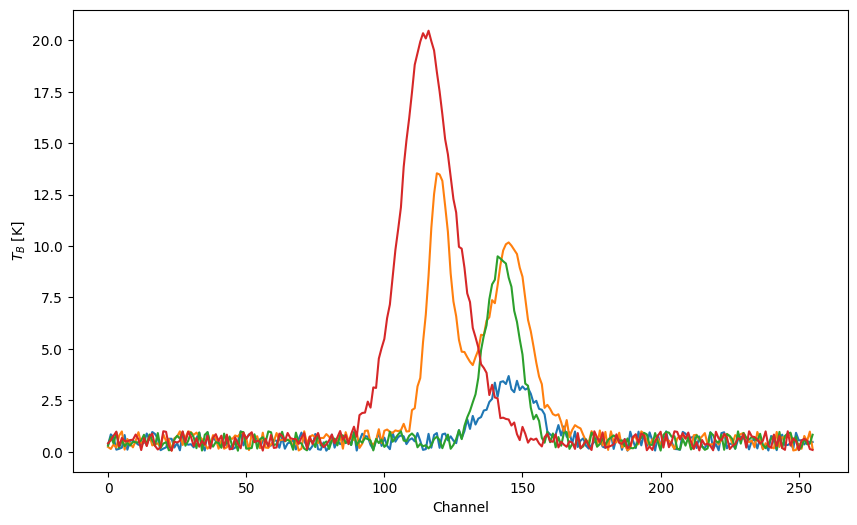

In [7]:
plt.figure(figsize=(10,6))
plt.plot(spectra[45:49].T)
plt.xlabel('Channel')
plt.ylabel(r'$T_B$ [K]')
plt.show()

### Create a dataloader from the dummy spectra

In [8]:
data_loader = DataLoader(
    TensorDataset(
        torch.Tensor(spectra).to(device)
    ), 
    batch_size=32, 
    shuffle=False
)

### Predict on the spectra

In [9]:
predictions = model.predict(data_loader, numPredictions=10).cpu().numpy()

Predicting: 100%|██████████| 10/10 [00:00<00:00, 28.67it/s]


### Take the average and standard deviation of the errors

In [10]:
avg_prediction = np.mean(predictions, axis = 0)
std_prediction = np.std(predictions, axis = 0)

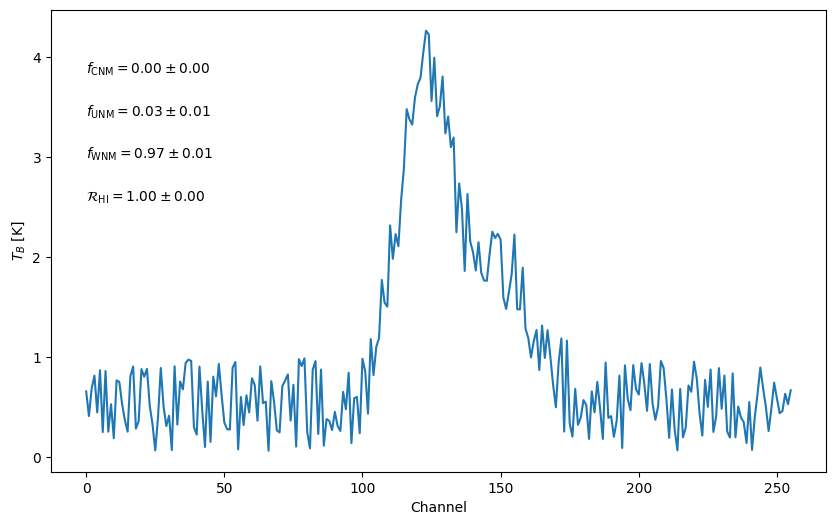

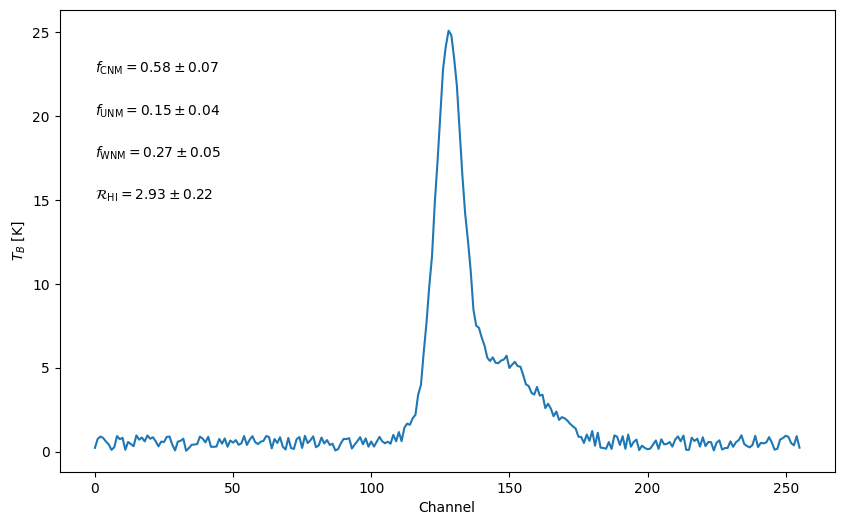

In [11]:
# Get the spectra with the highest and lowest predicted fcnm
min_cnm = np.argmin(avg_prediction[:,0])
max_cnm = np.argmax(avg_prediction[:,0])

BayesHI.plot_spectrum(spectra, predictions, min_cnm)
BayesHI.plot_spectrum(spectra, predictions, max_cnm)

## Train the network

In [12]:
# This reinitialises the model
model = BayesHI.load_model('bayeshi')

In [13]:
model = model.to(device)

### Generate dummy spectra and targets ($f_\text{CNM}$, $f_\text{UNM}$, $f_\text{WNM}$, $\mathcal{R}_\text{HI}$)

In [14]:
spectra = BayesHI.generate_spectra(num_spectra=10000, max_components=6)
# Fractions must sum to one
fractions = np.random.dirichlet(alpha=[1, 1, 1], size=10000)
rhi = 1 + np.random.exponential(scale=0.05, size=(10000,1))

targets = np.concatenate((fractions,rhi),axis=1)

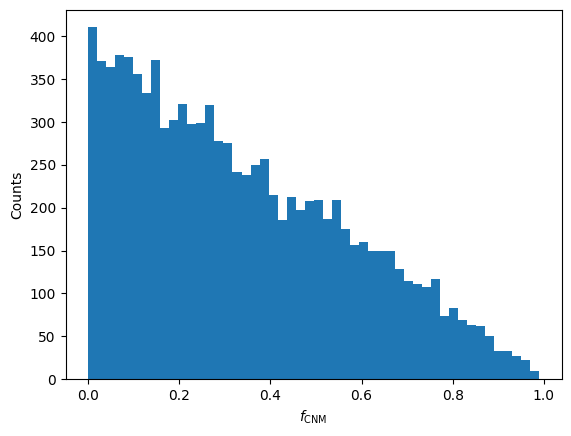

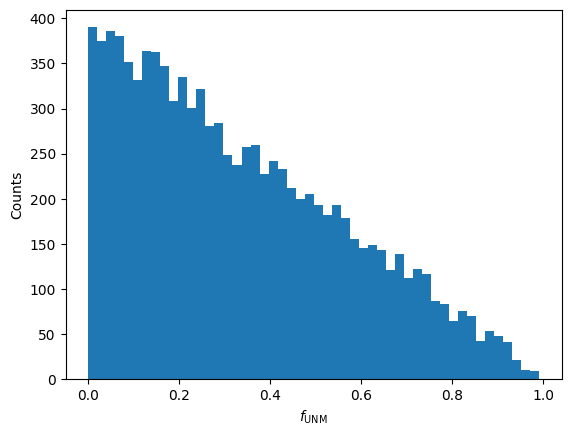

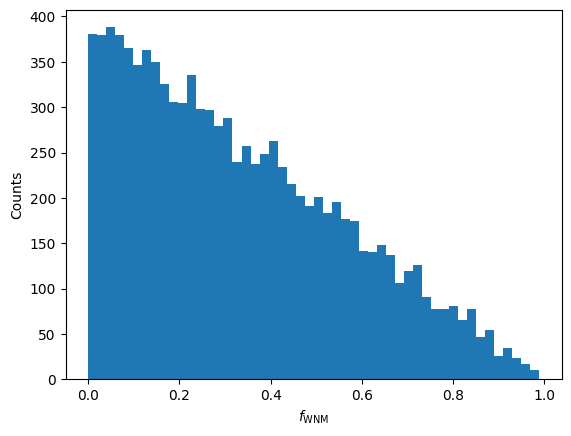

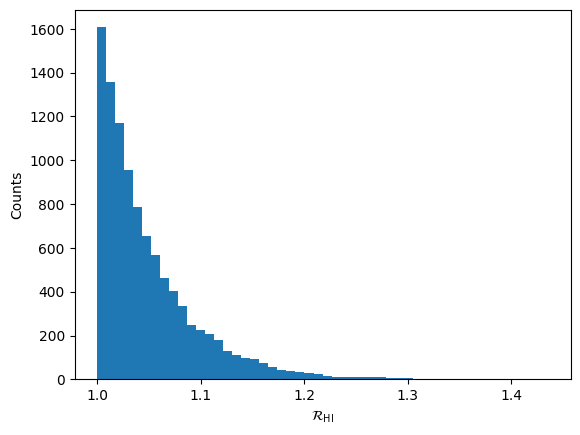

In [15]:
plt.hist(targets[:,0],bins=50)
plt.xlabel(r'$f_\text{CNM}$')
plt.ylabel('Counts')
plt.show()

plt.hist(targets[:,1],bins=50)
plt.xlabel(r'$f_\text{UNM}$')
plt.ylabel('Counts')
plt.show()

plt.hist(targets[:,2],bins=50)
plt.xlabel(r'$f_\text{WNM}$')
plt.ylabel('Counts')
plt.show()

plt.hist(targets[:,3],bins=50)
plt.xlabel(r'$\mathcal{R}_\text{HI}$')
plt.ylabel('Counts')
plt.show()

### Create a dataloader from the dummy spectra and targets

In [16]:
# Split into train and validation sets with 80:20 split
X_train, X_val, y_train, y_val = train_test_split(spectra, targets, test_size=0.2, random_state=42)

train_loader = DataLoader(
    TensorDataset(
        torch.Tensor(X_train).to(device),
        torch.Tensor(y_train).to(device)
    ), 
    batch_size=32, 
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_val).to(device),
        torch.tensor(y_val).to(device)
    ),
    batch_size=32,
    shuffle=False
)

### Train the network

In [17]:
train_errors, val_errors, trained_epochs, epoch_times = model.fit(train_loader, val_loader, './checkpoints/dummy_bayeshi.pth', nEpochs=50)

Training Model
Initial learning rate: [0.0001]
Epoch [1/50], Train Loss: 0.2958, Validation Loss: 0.1696, took 4.61s
Epoch [2/50], Train Loss: 0.1848, Validation Loss: 0.1631, took 4.42s
Epoch [3/50], Train Loss: 0.1601, Validation Loss: 0.1584, took 4.42s
Epoch [4/50], Train Loss: 0.1644, Validation Loss: 0.1541, took 4.42s
Epoch [5/50], Train Loss: 0.1643, Validation Loss: 0.1677, took 4.42s
Epoch [6/50], Train Loss: 0.1628, Validation Loss: 0.1589, took 4.41s
Epoch [7/50], Train Loss: 0.1671, Validation Loss: 0.1621, took 4.39s
Epoch [8/50], Train Loss: 0.1618, Validation Loss: 0.1560, took 4.41s
Epoch [9/50], Train Loss: 0.1620, Validation Loss: 0.1670, took 4.41s
Epoch [10/50], Train Loss: 0.1616, Validation Loss: 0.1578, took 4.39s
Epoch [11/50], Train Loss: 0.1624, Validation Loss: 0.1618, took 4.41s
Epoch [12/50], Train Loss: 0.1672, Validation Loss: 0.1554, took 4.40s
Epoch [13/50], Train Loss: 0.1583, Validation Loss: 0.1642, took 4.39s
Epoch [14/50], Train Loss: 0.1651, Vali

### Load the trained network parameters

In [18]:
model.load_weights('./checkpoints/dummy_bayeshi.pth')

Loading model from ./checkpoints/dummy_bayeshi.pth
Model loaded successfully


### Plot training and testing losses

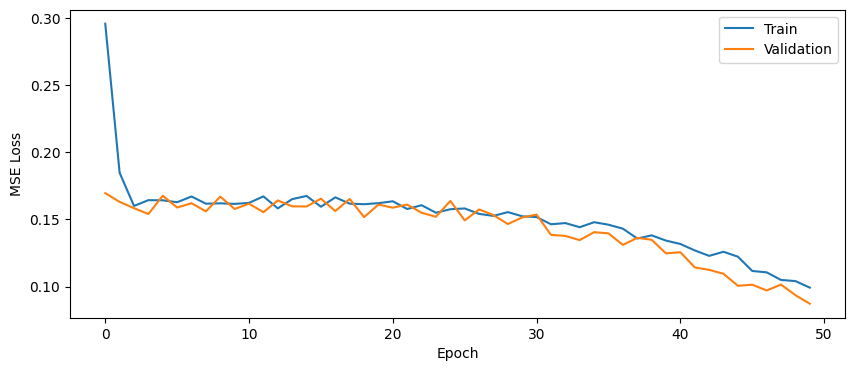

In [19]:
plt.figure(figsize=(10,4))
plt.plot(train_errors, label='Train')
plt.plot(val_errors, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Get test loss and predict on a test set

In [30]:
test_spectra = BayesHI.generate_spectra(num_spectra=1000, max_components=6)

test_fractions = np.random.dirichlet(alpha=[1, 1, 1], size=1000)
test_rhi = 1 + np.random.exponential(scale=0.05, size=(1000,1))
test_targets = np.concatenate((test_fractions, test_rhi),axis=1)

test_loader = DataLoader(
    TensorDataset(
        torch.Tensor(test_spectra).to(device),
        torch.Tensor(test_targets).to(device)
    ), 
    batch_size=32, 
    shuffle=False
)

In [31]:
from torch import nn
test_loss = model.evaluate(test_loader, nn.MSELoss())
print('Test loss (MSE):', test_loss)

Test loss (MSE): 0.08857429004274309


In [32]:
test_predictions = model.predict(test_loader, numPredictions=10).cpu().numpy()

Predicting: 100%|██████████| 10/10 [00:00<00:00, 26.02it/s]


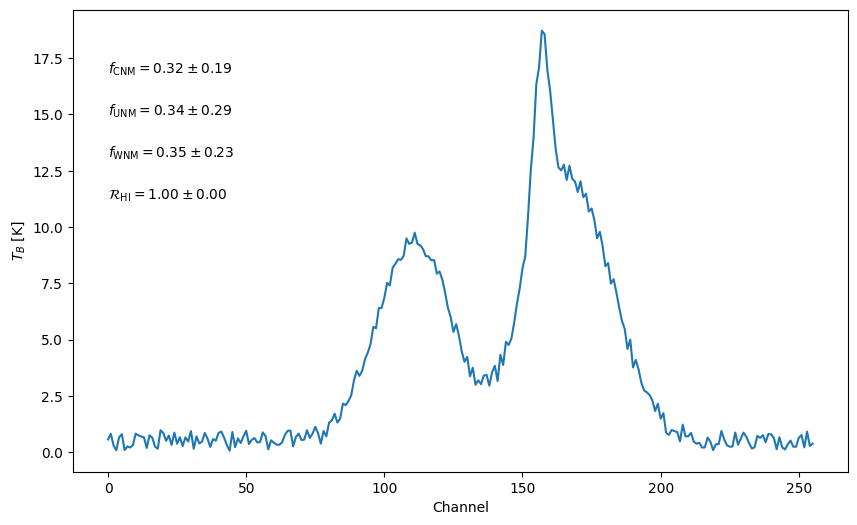

In [33]:
BayesHI.plot_spectrum(test_spectra, test_predictions, 8)

### Plot some one-to-one plots

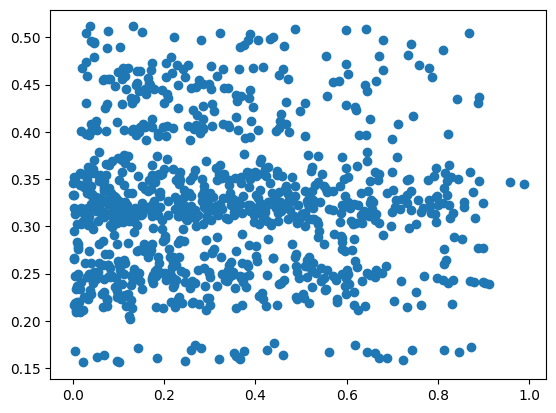

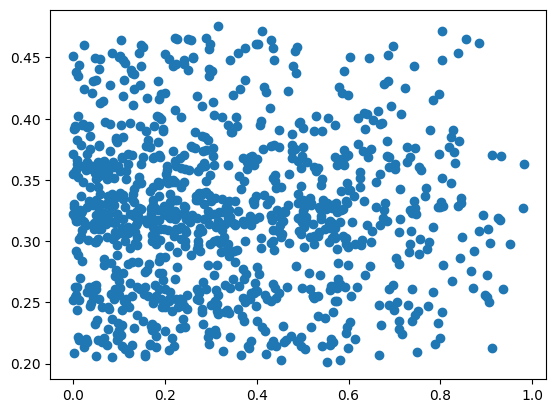

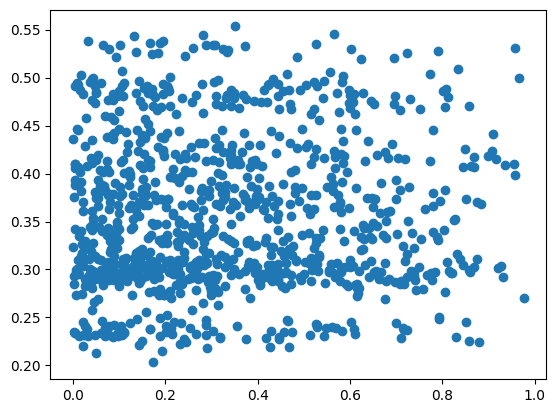

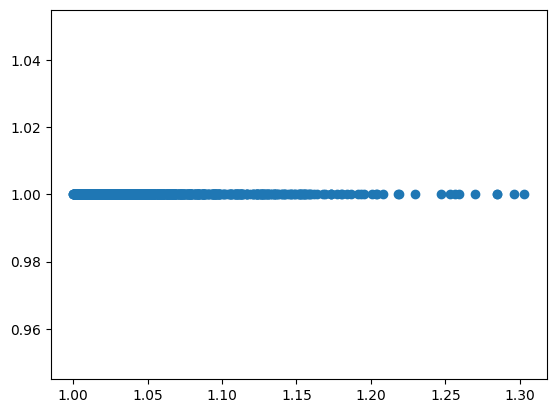

In [34]:
for i in range(4):
    plt.scatter(test_targets[:,i], np.mean(test_predictions,axis=0)[:,i])
    plt.show()